# Project

In [179]:
EPOCHS = 20000
ITERS_PER_BATCH = 40
MINI_BATCH_SIZE = 256
DPI_PLOTS = 200
MAX_RUNTIME = 60
FRAME_ANIMATION = 100
LEARNING_RATE_DECAY = 0.999
DOWNLOAD_AND_STORE = False
SHOW_ANIMATION = False
# one from:
# - "mse",
# - "robust_lin_reg",
# - "cross_entropy_regularized"
LOSS = "cross_entropy_regularized"
# one from:
# - mnist
# - cat-vs-dog
# - bio-or-not
DATASET = "cat-vs-dog"


In [180]:
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
import os
import time
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [181]:
def decode_image(image_file_names, FINAL_SIZE, PAD_CROP_SIZE):
    images = []
    for image_path in image_file_names:
        image = np.array(Image.open(image_path))
        if len(image.shape) < 3:
            image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        try:
            images.append(
                tf.image.rgb_to_grayscale(
                    tf.image.resize(
                        tf.image.resize_with_crop_or_pad(image, PAD_CROP_SIZE, PAD_CROP_SIZE),
                        (FINAL_SIZE, FINAL_SIZE)
                    )
                )
            )
        except:
            print("Error loading:", image_path)
    return images

In [182]:
if DATASET == "mnist":
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test))
    targets = np.concatenate((y_train, y_test)).astype("int")
    data = data[np.logical_or(targets == 0, targets == 1)]
    targets = targets[np.logical_or(targets == 0, targets == 1)]
    data = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(data.reshape((data.shape[0], -1))))
elif DATASET == "cat-vs-dog":
    if DOWNLOAD_AND_STORE:
        DATA_DIR = "datasets/cat-vs-dog/"
        SIZE = 100
        PAD_CROP_SIZE = 500
        print("Locating images 'cats or dog'")
        cats_train_image_file_names = [DATA_DIR+"cat/"+i for i in sorted(os.listdir(DATA_DIR+"cat")) if not i.startswith(".")][0:7000]
        dogs_train_image_file_names = [DATA_DIR+"dog/"+i for i in sorted(os.listdir(DATA_DIR+"dog")) if not i.startswith(".")][0:7000]
        print("Loading images")
        cats = np.array(decode_image(cats_train_image_file_names, SIZE, PAD_CROP_SIZE))
        dogs = np.array(decode_image(dogs_train_image_file_names, SIZE, PAD_CROP_SIZE))
        print("Shuffling images")
        data = np.concatenate((cats, dogs)).reshape((-1, SIZE*SIZE))
        shuffle = np.random.permutation(list(range(0, len(data))))
        targets = np.concatenate((np.zeros(len(cats)), np.ones(len(dogs))))
        data = data[shuffle]
        targets = targets[shuffle]
        plt.imshow(1-cats[3].reshape((SIZE, SIZE)), cmap="gray")
        print("Applying PCA")
        data = MinMaxScaler().fit_transform(PCA(n_components=300).fit_transform(data.reshape((data.shape[0], -1))))
        print("Saving in filesystem")
        with open('datasets/cat-vs-dog/loaded-rescaled-data.npy', 'wb') as f:
            np.save(f, data)
        with open('datasets/cat-vs-dog/loaded-rescaled-targets.npy', 'wb') as f:
            np.save(f, targets)
    else:
        print("Loading from cached file 'cats or dog'")
        with open('datasets/cat-vs-dog/loaded-rescaled-data.npy', 'rb') as f:
            data = np.load(f)
        with open('datasets/cat-vs-dog/loaded-rescaled-targets.npy', 'rb') as f:
            targets = np.load(f)
elif DATASET == "bio-or-not":
    if DOWNLOAD_AND_STORE:
        DATA_DIR = "datasets/bio-or-not/"
        SIZE = 100
        PAD_CROP_SIZE = 200
        print("Locating images 'bio or not'")
        bio_train_image_file_names = [DATA_DIR+"bio/"+i for i in sorted(os.listdir(DATA_DIR+"bio")) if not i.startswith(".")][0:7000]
        not_train_image_file_names = [DATA_DIR+"not/"+i for i in sorted(os.listdir(DATA_DIR+"not")) if not i.startswith(".")][0:7000]
        print("Loading images")
        bios = np.array(decode_image(bio_train_image_file_names, SIZE, PAD_CROP_SIZE))
        nots = np.array(decode_image(not_train_image_file_names, SIZE, PAD_CROP_SIZE))
        print("Shuffling images")
        data = np.concatenate((bios, nots)).reshape((-1, SIZE*SIZE))
        shuffle = np.random.permutation(list(range(0, len(data))))
        targets = np.concatenate((np.zeros(len(bios)), np.ones(len(nots))))
        data = data[shuffle]
        targets = targets[shuffle]
        plt.imshow(1-bios[3].reshape((SIZE, SIZE)), cmap="gray")
        print("Applying PCA")
        data = MinMaxScaler().fit_transform(PCA(n_components=300).fit_transform(data.reshape((data.shape[0], -1))))
        print("Saving in filesystem")
        with open('datasets/bio-or-not/loaded-rescaled-data.npy', 'wb') as f:
            np.save(f, data)
        with open('datasets/bio-or-not/loaded-rescaled-targets.npy', 'wb') as f:
            np.save(f, targets)
    else:
        print("Loading from cached file 'bio or not'")
        with open('datasets/bio-or-not/loaded-rescaled-data.npy', 'rb') as f:
            data = np.load(f)
        with open('datasets/bio-or-not/loaded-rescaled-targets.npy', 'rb') as f:
            targets = np.load(f)

Loading from cached file 'cats or dog'


In [183]:
if SHOW_ANIMATION:
    indexes = np.random.choice(list(range(len(data))), 1000)
    data = data[indexes]
    targets = targets[indexes]
    data = MinMaxScaler().fit_transform(PCA(n_components=2).fit_transform(data))

In [184]:
data = data[:-(len(data)%MINI_BATCH_SIZE)]
targets = targets[:-(len(targets)%MINI_BATCH_SIZE)]

In [185]:
starting_point = np.zeros(data.shape[1])
starting_point.fill(1)

In [186]:
# weights_count = data.shape[1]
# hessian = np.zeros((weights_count, weights_count))
# for i in range(weights_count):
#     for j in range(weights_count):
#         if i == j:
#             hessian[i, j] = data[:,i].T@data[:,i] * 2
#         else:
#             hessian[i, j] = data[:,i].T@data[:,j] * 2
#
# eigenvalues = np.linalg.eig(hessian)[0]
# L = np.max(eigenvalues)
# sigma = np.min(eigenvalues)
# STEPSIZE = 1 / L # 2 / (L + sigma)

In [187]:
chunked_data = data.reshape((data.shape[0] // MINI_BATCH_SIZE, -1, data.shape[1]))
chunked_target = targets.reshape((targets.shape[0] // MINI_BATCH_SIZE, -1))

## Loss & Grad

In [188]:
#MIN SQUARE ERROR (CONVEX)
def loss_mse(data, targets, w):
    return np.square(data@w - targets).mean()
def grad_mse_array(data, params, targets):
    return -1 / data.shape[0] * data.T @ (targets - data @ params)
def grad_mse_single(sample, params, target):
    return -1 * (target - sample @ params) * sample


# ROBUST LINEAR REGRESSION (NON CONVEX)
def loss_robust_lin_reg(data, targets, w):
    return np.log(np.square(targets - data@w)/2 + 1).mean()
def grad_robust_lin_reg_single(sample, w, target):
    return 1/((target - sample@w)**2 / 2 + 1) * (target - sample@w) * -sample
def grad_robust_lin_reg_array(data, w, targets):
    return (1/
            ((targets - data@w)**2 / 2 + 1) *
            (targets - data@w) @
            -data)/ data.shape[0]


# CROSS ENTROPY WITH REGULARIZER (NON CONVEX)
alpha = 1/10
def loss_cross_entropy_regularized(data, targets, w):
    return (
                   -np.log(1e-10 + 1/(1+ np.exp(-np.dot(data, w).astype("float64")))) * targets
                   -np.log(1e-10 + 1 - 1/(1+ np.exp(-np.dot(data, w).astype("float64")))) * (1-targets)
           ).mean() + \
           (w**2 / (w**2 + 1)).sum() * alpha
def grad_cross_entropy_regularized_single(sample, w, target):
    return (-target * np.exp(-np.dot(sample, w)) + (1-target)) / (1 + np.exp(-np.dot(sample, w))) * sample + 2*w / (w**2 + 1)**2 * alpha
def grad_cross_entropy_regularized_array(data, w, targets):
    return ((-targets * np.exp(-np.dot(data, w)) + (1-targets)) /
             (1 + np.exp(-np.dot(data, w))) @ data) / data.shape[0] + (2*w / (w**2 + 1)**2) * alpha

assert LOSS in ["mse", "robust_lin_reg", "cross_entropy_regularized"]
# PROXY
def loss(data, w, targets):
    if LOSS == "robust_lin_reg":
        return loss_robust_lin_reg(data, targets, w)
    elif LOSS == "mse":
        return loss_mse(data, targets, w)
    elif LOSS == "cross_entropy_regularized":
        return loss_cross_entropy_regularized(data, targets, w)
def grad_single(sample, w, target):
    if LOSS == "robust_lin_reg":
        return grad_robust_lin_reg_single(sample, w, target)
    elif LOSS == "mse":
        return grad_mse_single(sample, w, target)
    elif LOSS == "cross_entropy_regularized":
        return grad_cross_entropy_regularized_single(sample, w, target)
def grad_array(data, w, targets):
    if LOSS == "robust_lin_reg":
        return grad_robust_lin_reg_array(data, w, targets)
    elif LOSS == "mse":
        return grad_mse_array(data, w, targets)
    elif LOSS == "cross_entropy_regularized":
        return grad_cross_entropy_regularized_array(data, w, targets)

In [189]:
import plotly.graph_objects as go
if SHOW_ANIMATION and data.shape[1] == 2:
    starting_point = np.array([40, 80])
    x = np.linspace(-5,50, 100)
    y = np.linspace(-5,90, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([
        [loss(data, np.array([x,y]), targets) for x,y in zip(x_r, y_r)]
        for x_r, y_r in zip(X,Y)
    ])

    fig = go.Figure(data=[
        go.Scatter3d(
            name="Starting point",
            x=[starting_point[0]], y=[starting_point[1]], z=[loss(data, starting_point, targets)],
            marker=dict(
                size=5,
                color="red",
                colorscale='Viridis',
            ),
        ),
        go.Surface(
            showscale=False,
            z=Z, x=X, y=Y,
            colorscale="Viridis",
            colorbar=None
        ),
    ], )
    import json
    camera = json.loads("{'center': {'x': 0.006366696856033653, 'y': -0.05218330435246074, 'z': -0.0739852163325267}, 'eye': {'x': -0.7885156751277191, 'y': -1.1561474889685182, 'z': 0.7659138958640532}}".replace("'", '"'))
    fig.update_layout(scene_camera=camera)

    fig.update_layout(
        width=1600,height=1000,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual'
        ),
    )
    fig.show(renderer="browser")

In [190]:
# USING PCA TOP 300
# Starting from [1,1,...,1]
STEP_SIZES = {
    "mnist": {
        "mse": {
            "SGD": 0.01,
            "SAG": 0.0005,
            "SAGA": 0.001,
            "SVGR": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.01,
            "SpiderBoost": 0.05,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.08,
            "SAG": 0.01,
            "SAGA": 0.01,
            "SVGR": 0.01,
            "SARAH": 0.005,
            "SARAH+": 0.005,
            "SpiderBoost": 0.5,
            "SNVRG": 0.5,
        },
        "cross_entropy_regularized": {
            "SGD": 0.1,
            "SAG": 0.01,
            "SAGA": 0.01,
            "SVGR": 0.01,
            "SARAH": 0.01,
            "SARAH+": 0.05,
            "SpiderBoost": 0.5,
            "SNVRG": 0.5,
        }
    },
    "cat-vs-dog": {
        "mse": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVGR": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.001,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.005,
            "SAG": 0.05,
            "SAGA": 0.01,
            "SVGR": 0.005,
            "SARAH": 0.005,
            "SARAH+": 0.005,
            "SpiderBoost": 0.01,
            "SNVRG": 2,
        },
        "cross_entropy_regularized": {
            "SGD": 0.03,
            "SAG": 0.01,
            "SAGA": 0.02,
            "SVGR": 0.01,
            "SARAH": 0.01,
            "SARAH+": 0.01,
            "SpiderBoost": 0.05,
            "SNVRG": 2,
        }
    },
    "bio-or-not": {
        "mse": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVGR": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.001,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.005,
            "SAG": 0.01,
            "SAGA": 0.01,
            "SVGR": 0.005,
            "SARAH": 0.005,
            "SARAH+": 0.005,
            "SpiderBoost": 0.002,
            "SNVRG": 2,
        },
        "cross_entropy_regularized": {
            "SGD": 0.03,
            "SAG": 0.03,
            "SAGA": 0.03,
            "SVGR": 0.02,
            "SARAH": 0.02,
            "SARAH+": 0.02,
            "SpiderBoost": 0.05,
            "SNVRG": 2,
        }
    }
}

## SGD

In [191]:
%%time
w = np.copy(starting_point)
track_loss_sgd = [loss(data, w, targets)]
track_time_sgd = [0]
track_w_sgd = [w]
time_counter = time.time()
start =  time.time()
step = STEP_SIZES[DATASET][LOSS]["SGD"]

for _ in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    for _ in range(2):
        for c_data, c_targets in zip(chunked_data, chunked_target):
            for _ in range(ITERS_PER_BATCH):
                index = np.random.randint(0, c_data.shape[0])
                w = w - step * grad_single(c_data[index], w, c_targets[index])
                step *= LEARNING_RATE_DECAY

                track_time_sgd.append(time.time() - start)
                track_loss_sgd.append(loss(data, w, targets))
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sgd.append(w)

CPU times: user 6min 44s, sys: 9min 9s, total: 15min 54s
Wall time: 1min 47s


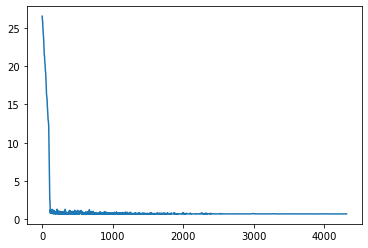

In [192]:
plt.plot(track_loss_sgd)

## SAG

In [193]:
%%time
w = np.copy(starting_point)
track_loss_sag = [loss(data, w, targets)]
start =  time.time()
track_w_sag = [w]
time_counter = time.time()
track_time_sag = [0]
step = STEP_SIZES[DATASET][LOSS]["SAG"]

for _ in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    for _ in range(2):
        for c_data, c_targets in zip(chunked_data, chunked_target):
            g = np.array([grad_single(c_data[i], w, c_targets[i]) for i in range(c_data.shape[0])])
            for _ in range(ITERS_PER_BATCH):
                index = np.random.randint(0, c_data.shape[0])
                g[index] = grad_single(c_data[index], w, c_targets[index])
                w = w - step * np.mean(g, axis=0)

                track_time_sag.append(time.time() - start)
                track_loss_sag.append(loss(data, w, targets))
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sag.append(w)
                step *= LEARNING_RATE_DECAY

CPU times: user 6min 55s, sys: 10min 35s, total: 17min 31s
Wall time: 1min 58s


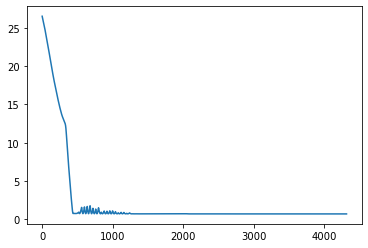

In [194]:
plt.plot(track_loss_sag)

## SAGA

In [195]:
%%time
w = np.copy(starting_point)
track_loss_saga = [loss(data, w, targets)]
start =  time.time()
track_time_saga = [0]
track_w_saga = [w]
time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SAGA"]

for i in range(EPOCHS):
    for _ in range(2):
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            g = np.array([grad_single(c_data[i], w, c_targets[i]) for i in range(c_data.shape[0])])
            for _ in range(ITERS_PER_BATCH):
                index = np.random.randint(0, c_data.shape[0])
                gradient = grad_single(c_data[index], w, c_targets[index])
                w = w - step * (np.mean(g, axis=0)  - g[index] + gradient)
                g[index] = gradient
                step *= LEARNING_RATE_DECAY

                track_time_saga.append(time.time() - start)
                track_loss_saga.append(loss(data, w, targets))

                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_saga.append(w)

CPU times: user 3min 46s, sys: 5min 15s, total: 9min 2s
Wall time: 1min


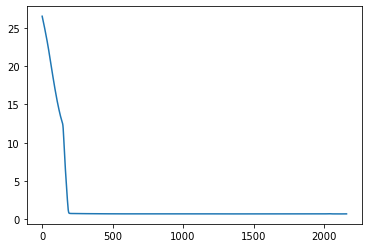

In [196]:
plt.plot(track_loss_saga)

## SVGR

In [197]:
%%time
w = np.copy(starting_point)
track_loss_svrg = [loss(data, w, targets)]
start =  time.time()
track_time_svrg = [0]
track_w_svrg = [w]
time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SVGR"]

for i in range(EPOCHS):
    for _ in range(2):
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                w_tilde = np.copy(w)
                avg_gradients = np.mean([grad_single(c_data[i], w, c_targets[i]) for i in range(c_data.shape[0])], axis=0)
                for j in range(c_data.shape[0] // 4):
                    index = np.random.randint(0, c_data.shape[0])
                    current_grad = grad_single(c_data[index], w, c_targets[index])
                    w = w - step * (
                            grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_tilde, c_targets[index]) +
                            avg_gradients
                    )
                    track_time_svrg.append(time.time() - start)
                    track_loss_svrg.append(loss(data, w, targets))
                    if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                        time_counter = time.time()
                        track_w_svrg.append(w)
                step *= LEARNING_RATE_DECAY


CPU times: user 4min 4s, sys: 6min 34s, total: 10min 39s
Wall time: 1min 11s


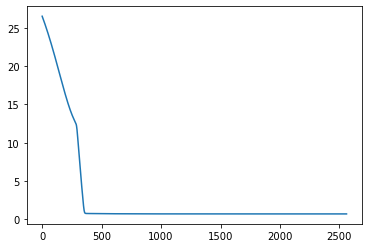

In [198]:
plt.plot(track_loss_svrg)

## SARAH

In [199]:
%%time
w = np.copy(starting_point)
track_loss_sarah = [loss(data, w, targets)]
start =  time.time()
track_time_sarah = [0]
track_w_sarah = [w]
time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SARAH"]

for i in range(EPOCHS):
    for _ in range(2):
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                w_0 = np.copy(w)
                v_0 = grad_array(c_data, w, c_targets)
                w = w_0 - step * v_0
                for t in range(np.random.randint(0, c_data.shape[0] // 8)):
                    index = np.random.randint(0, c_data.shape[0])
                    v_0 = (
                            grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_0, c_targets[index]) +
                            v_0
                    )
                    w_0 = np.copy(w)
                    w = w - step * v_0

                    track_time_sarah.append(time.time() - start)
                    track_loss_sarah.append(loss(data, w, targets))
                    if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                        time_counter = time.time()
                        track_w_sarah.append(w)
                step *= LEARNING_RATE_DECAY

CPU times: user 4min 8s, sys: 5min 30s, total: 9min 39s
Wall time: 1min 4s


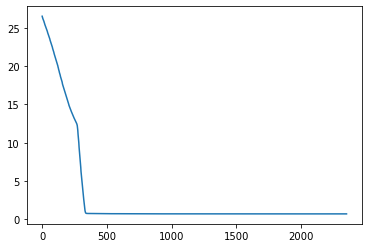

In [200]:
plt.plot(track_loss_sarah)

## SARAH+

In [201]:
%%time
w = np.copy(starting_point)
track_loss_sarah_plus = [loss(data, w, targets)]
start =  time.time()
track_time_sarah_plus = [0]
track_w_sarah_plus = [w]
time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SARAH+"]

for i in range(EPOCHS):
    for _ in range(2):
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                w_0 = np.copy(w)
                v_0 = grad_array(c_data, w, c_targets)
                w = w_0 - step * v_0
                v_t = np.copy(v_0)
                for t in range(c_data.shape[0] // 8):
                    if np.linalg.norm(v_t)**2 < 1/8 * (np.linalg.norm(v_0) ** 2):
                        break
                    index = np.random.randint(0, c_data.shape[0])
                    v_t = (
                            grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_0, c_targets[index]) +
                            v_t
                    )
                    w_0 = np.copy(w)
                    w = w - step * v_t

                    track_time_sarah_plus.append(time.time() - start)
                    track_loss_sarah_plus.append(loss(data, w, targets))
                    if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                        time_counter = time.time()
                        track_w_sarah_plus.append(w)
                step *= LEARNING_RATE_DECAY

CPU times: user 3min 40s, sys: 6min 36s, total: 10min 17s
Wall time: 1min 9s


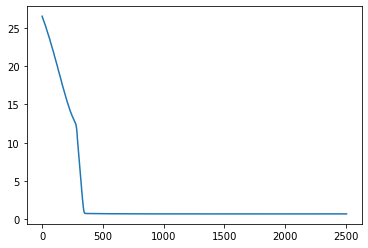

In [202]:
plt.plot(track_loss_sarah_plus)

## SpiderBoost

In [203]:
%%time
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_loss_spider_boost = [loss(data, w, targets)]
track_time_spider_boost = [0]
track_w_spider_boost = [w]
time_counter = time.time()

start =  time.time()
step = STEP_SIZES[DATASET][LOSS]["SpiderBoost"]


for i in range(EPOCHS):
    for _ in range(2):
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            all_indexes = list(range(c_data.shape[0]))
            v_previous = grad_array(c_data, w, c_targets)
            for i in range(ITERS_PER_BATCH):
                q = int(math.sqrt(c_data.shape[0]))
                if  i % q == 0:
                    vk = grad_array(c_data, w, c_targets)
                else:
                    sample_indexes = np.random.choice(all_indexes, q)
                    samples_data = c_data[sample_indexes]
                    samples_targets = c_targets[sample_indexes]

                    first = grad_array(samples_data, w, samples_targets)
                    second = grad_array(samples_data, w_previous, samples_targets)
                    vk = (first - second) + v_previous


                w_previous = np.copy(w)
                v_previous = np.copy(vk)
                w = w - step * vk
                track_time_spider_boost.append(time.time() - start)
                track_loss_spider_boost.append(loss(data, w, targets))
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_spider_boost.append(w)
                step *= LEARNING_RATE_DECAY

CPU times: user 3min 42s, sys: 5min 22s, total: 9min 4s
Wall time: 1min


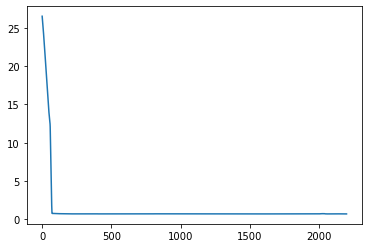

In [204]:
plt.plot(track_loss_spider_boost)

## SNVRG

In [205]:
def updateReferencePoints(wl_old, w, r, K):
    wl_new  = []
    for l in range(r):
        wl_new.append(wl_old[l])
    for l in range(r, K+1):
        wl_new.append(w)
    return np.array(wl_new)

def updateReferenceGradients(gl_old, wl_new, r, K, Bl, data, targets):
    gl_new  = []
    for l in range(r):
        gl_new.append(gl_old[l])
    for l in range(r, K+1):
        indexes = np.random.choice(list(range(data.shape[0])), Bl, replace=False)
        gl_new.append(grad_array(data[indexes], wl_new[l], targets[indexes]) - \
                    grad_array(data[indexes], wl_new[l-1], targets[indexes]))
    return gl_new

def oneEpochSNVRG(w, M, data, targets):
    w = np.copy(w)
    K = 2
    B = 256
    b = 2
    Bl = np.array([B/(b**(i+1)) for i in range(K+1)]).astype("int")
    Tl = np.array([b for _ in range(K+1)])
    wl = np.array([w for _ in range(K+1)])
    wl_previous = np.array([w for _ in range(K+1)])
    wl_history = [[w for _ in range(K+1)]]
    gl = np.array([np.zeros(np.shape(w)).tolist() for _ in range(K+1)])
    indexes = np.random.choice(list(range(data.shape[0])), B, replace=False)
    gl[0] = grad_array(data[indexes], w, targets[indexes])
    v = np.sum(gl, axis=0)
    w = w - 1/(10 * M) * v
    wl_history.append(np.copy(w))
    for t in range(1, np.prod(Tl) - 1):
        r = 0
        for j in range( K + 1):
            if t % np.prod(Tl[j+1:]) == 0:
                r = j
                break
        for l in range(K):
            wl = updateReferencePoints(wl_previous, w, r, K)
        for l in range(K):
            gl = updateReferenceGradients(gl, wl, r, K, Bl[l], data, targets)

        v = np.sum(gl, axis=0)
        wl_previous = np.copy(wl)
        w = w - 1/(10 * M) * v
        wl_history.append(np.copy(w))

    return wl_history[np.random.randint(wl.shape[0] - 1)], w

In [206]:
%%time
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_loss_snvrg = [loss(data, w, targets)]
track_time_snvrg = [0]
track_w_snvrg = [w]
time_counter = time.time()
start =  time.time()
M = STEP_SIZES[DATASET][LOSS]["SNVRG"]

for i in range(np.random.randint(EPOCHS)):

    for _ in range(2):
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                y_s, w = oneEpochSNVRG(w, M, c_data, c_targets)
                M /= LEARNING_RATE_DECAY

                track_time_snvrg.append(time.time() - start)
                track_loss_snvrg.append(loss(data, w, targets))
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_snvrg.append(w)

CPU times: user 4min, sys: 5min 28s, total: 9min 29s
Wall time: 1min 3s


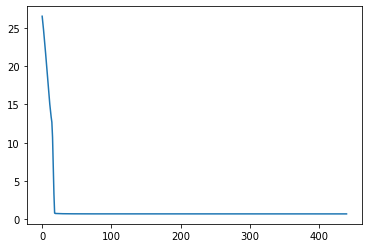

In [207]:
plt.plot(track_loss_snvrg)

## Plots

In [208]:
track_time_sgd = np.array(track_time_sgd)
track_time_sag = np.array(track_time_sag)
track_time_saga = np.array(track_time_saga)
track_time_sarah = np.array(track_time_sarah)
track_time_sarah_plus = np.array(track_time_sarah_plus)
track_time_spider_boost = np.array(track_time_spider_boost)
track_time_svrg = np.array(track_time_svrg)
track_time_snvrg = np.array(track_time_snvrg)

track_loss_sgd = np.array(track_loss_sgd)
track_loss_sag = np.array(track_loss_sag)
track_loss_saga = np.array(track_loss_saga)
track_loss_sarah = np.array(track_loss_sarah)
track_loss_sarah_plus = np.array(track_loss_sarah_plus)
track_loss_spider_boost = np.array(track_loss_spider_boost)
track_loss_svrg = np.array(track_loss_svrg)
track_loss_snvrg = np.array(track_loss_snvrg)


track_loss_sgd = track_loss_sgd[track_time_sgd < MAX_RUNTIME]
track_loss_sag = track_loss_sag[track_time_sag < MAX_RUNTIME]
track_loss_saga = track_loss_saga[track_time_saga < MAX_RUNTIME]
track_loss_sarah = track_loss_sarah[track_time_sarah < MAX_RUNTIME]
track_loss_sarah_plus = track_loss_sarah_plus[track_time_sarah_plus < MAX_RUNTIME]
track_loss_spider_boost = track_loss_spider_boost[track_time_spider_boost < MAX_RUNTIME]
track_loss_svrg = track_loss_svrg[track_time_svrg < MAX_RUNTIME]
track_loss_snvrg = track_loss_snvrg[track_time_snvrg < MAX_RUNTIME]

track_time_sgd = track_time_sgd[track_time_sgd < MAX_RUNTIME]
track_time_sag = track_time_sag[track_time_sag < MAX_RUNTIME]
track_time_saga = track_time_saga[track_time_saga < MAX_RUNTIME]
track_time_sarah = track_time_sarah[track_time_sarah < MAX_RUNTIME]
track_time_sarah_plus = track_time_sarah_plus[track_time_sarah_plus < MAX_RUNTIME]
track_time_spider_boost = track_time_spider_boost[track_time_spider_boost < MAX_RUNTIME]
track_time_svrg = track_time_svrg[track_time_svrg < MAX_RUNTIME]
track_time_snvrg = track_time_snvrg[track_time_snvrg < MAX_RUNTIME]

In [209]:
min = np.min(
    np.concatenate((
        track_loss_sarah,
        track_loss_sarah_plus,
        track_loss_snvrg,
        track_loss_sag,
        track_loss_saga,
        track_loss_snvrg,
        track_loss_spider_boost,
        track_loss_sgd,
    ))
)

In [210]:
min

0.6929481634617346

### Iterations

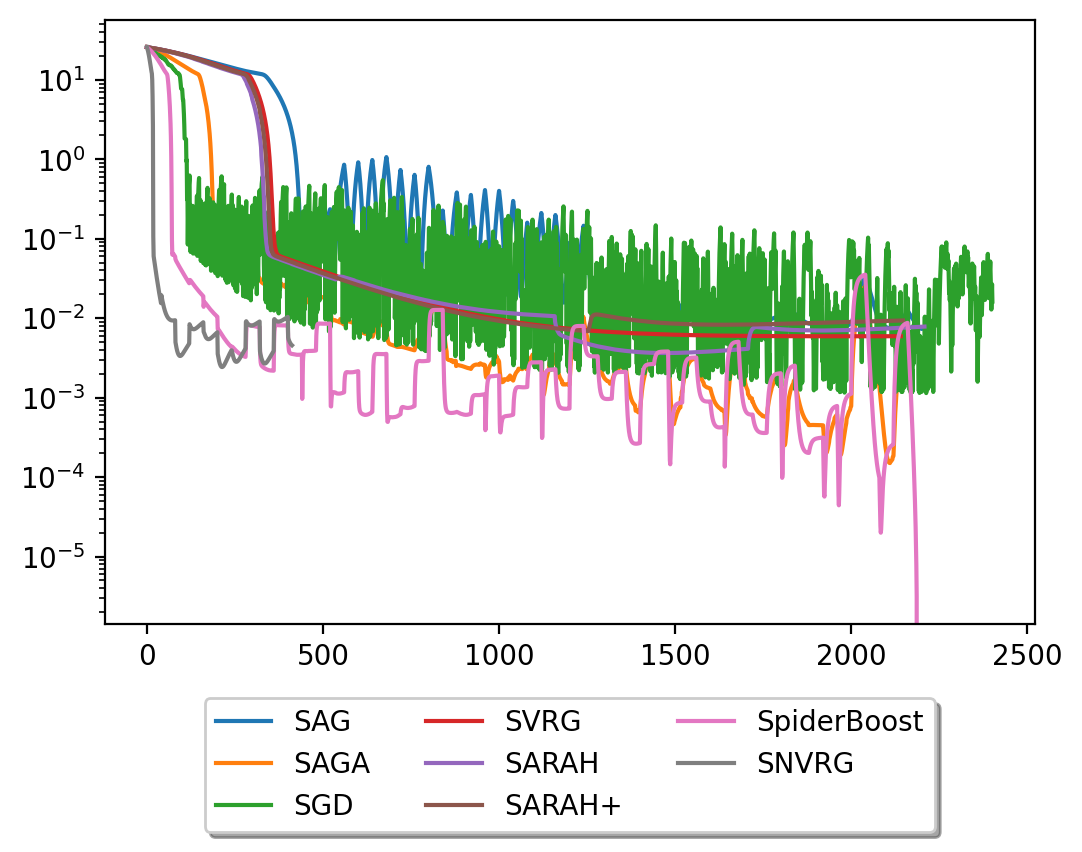

In [211]:
plt.figure(dpi=DPI_PLOTS)

plt.semilogy(track_loss_sag - min)
plt.semilogy(track_loss_saga - min)
plt.semilogy(track_loss_sgd - min)
plt.semilogy(track_loss_svrg - min)
plt.semilogy(track_loss_sarah - min)
plt.semilogy(track_loss_sarah_plus - min)
plt.semilogy(track_loss_spider_boost - min)
plt.semilogy(track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

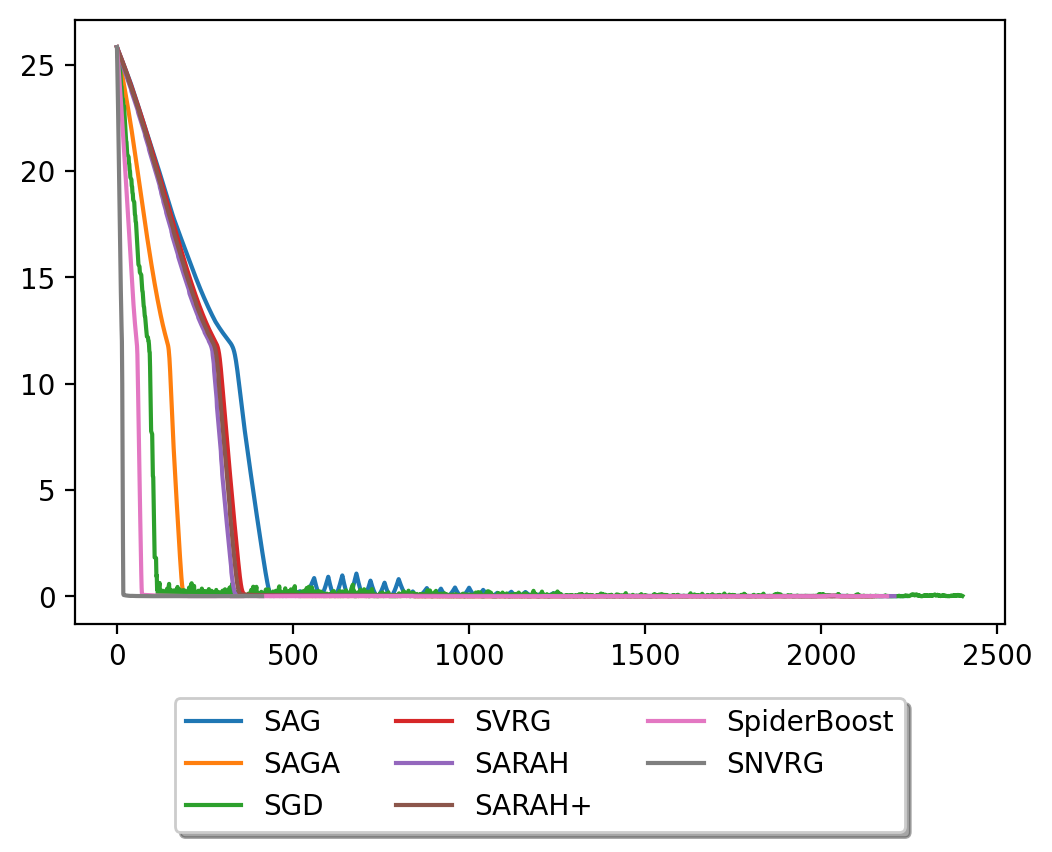

In [212]:
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_loss_sag - min)
plt.plot(track_loss_saga - min)
plt.plot(track_loss_sgd - min)
plt.plot(track_loss_svrg - min)
plt.plot(track_loss_sarah - min)
plt.plot(track_loss_sarah_plus - min)
plt.plot(track_loss_spider_boost - min)
plt.plot(track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

### Time

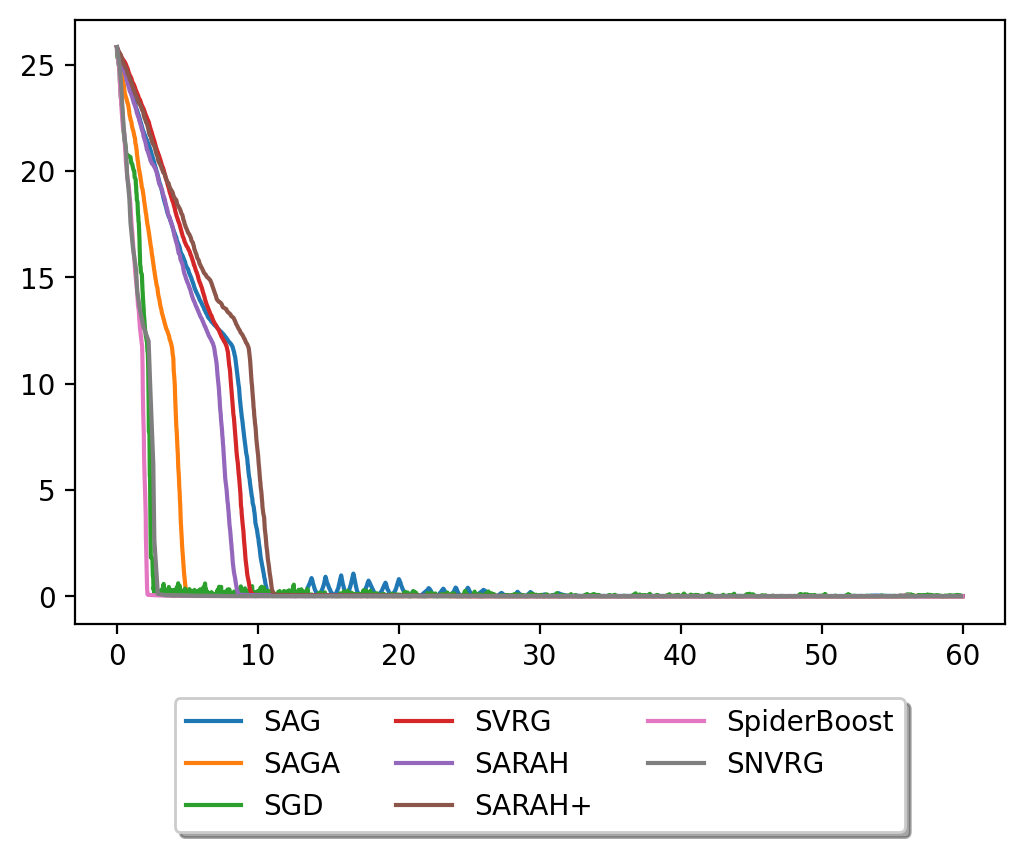

In [213]:
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_time_sag, track_loss_sag - min)
plt.plot(track_time_saga, track_loss_saga - min)
plt.plot(track_time_sgd, track_loss_sgd - min)
plt.plot(track_time_svrg, track_loss_svrg - min)
plt.plot(track_time_sarah, track_loss_sarah - min)
plt.plot(track_time_sarah_plus, track_loss_sarah_plus - min)
plt.plot(track_time_spider_boost, track_loss_spider_boost - min)
plt.plot(track_time_snvrg, track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

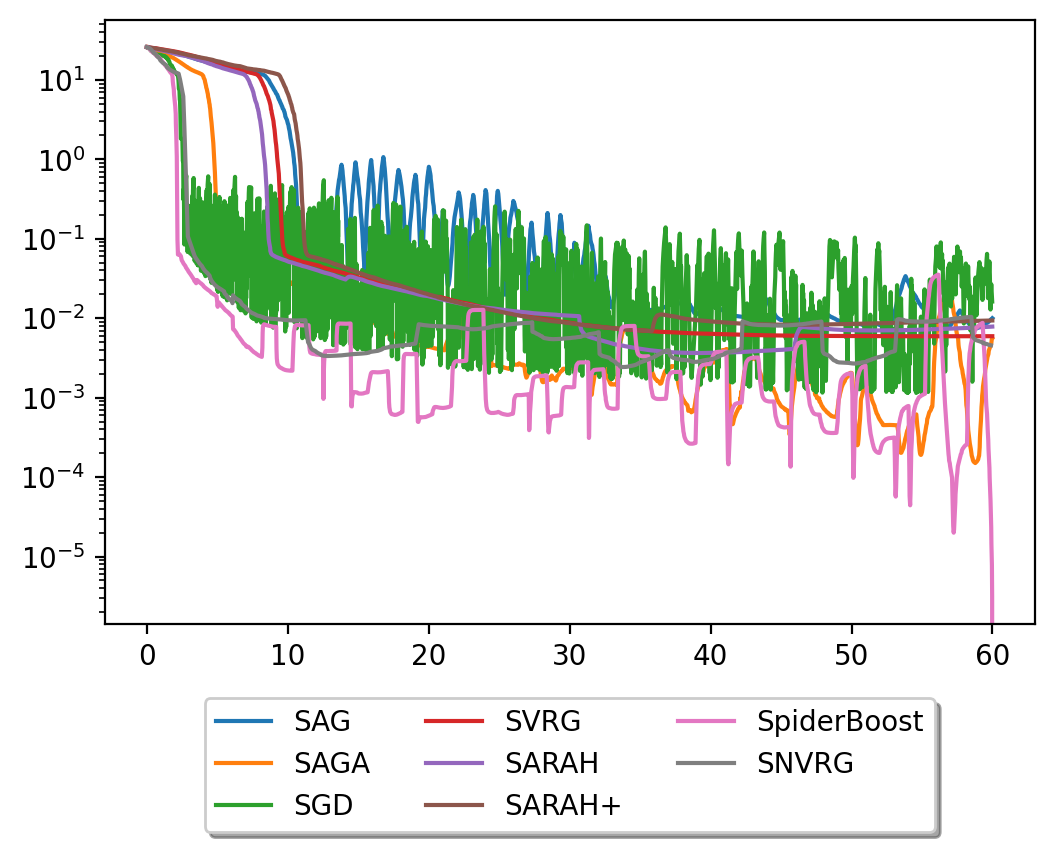

In [214]:
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_time_sag, track_loss_sag - min)
plt.semilogy(track_time_saga, track_loss_saga - min)
plt.semilogy(track_time_sgd, track_loss_sgd - min)
plt.semilogy(track_time_svrg, track_loss_svrg - min)
plt.semilogy(track_time_sarah, track_loss_sarah - min)
plt.semilogy(track_time_sarah_plus, track_loss_sarah_plus - min)
plt.semilogy(track_time_spider_boost, track_loss_spider_boost - min)
plt.semilogy(track_time_snvrg, track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

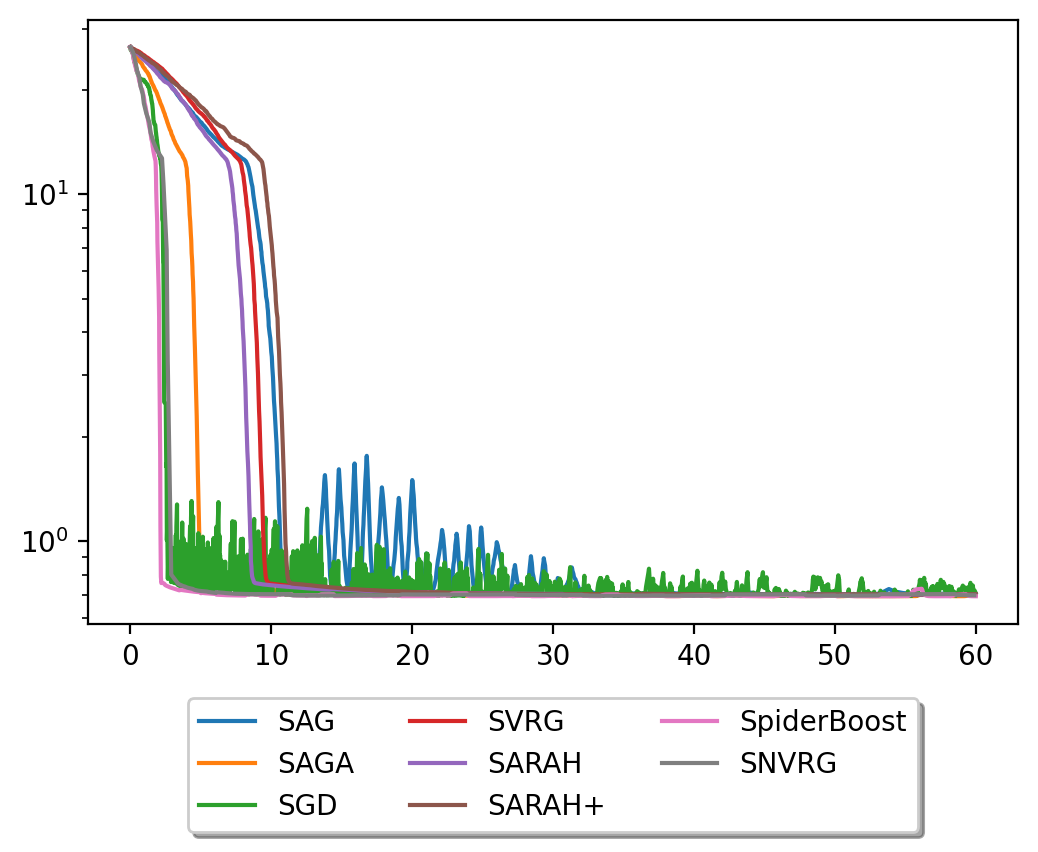

In [215]:
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_time_sag, track_loss_sag)
plt.semilogy(track_time_saga, track_loss_saga)
plt.semilogy(track_time_sgd, track_loss_sgd)
plt.semilogy(track_time_svrg, track_loss_svrg)
plt.semilogy(track_time_sarah, track_loss_sarah)
plt.semilogy(track_time_sarah_plus, track_loss_sarah_plus)
plt.semilogy(track_time_spider_boost, track_loss_spider_boost)
plt.semilogy(track_time_snvrg, track_loss_snvrg)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

## Animation

In [216]:
import plotly.graph_objects as go
if SHOW_ANIMATION and data.shape[1] == 2:
    x_range = (-30,80)
    y_range = (-30,80)
    x = np.linspace(*x_range, 50)
    y = np.linspace(*y_range, 50)
    X, Y = np.meshgrid(x, y)
    Z = np.array([
        [loss(data, np.array([x,y]), targets) for x,y in zip(x_r, y_r)]
        for x_r, y_r in zip(X,Y)
    ])

    tracks = [
        track_w_sgd, track_w_svrg,
        track_w_sarah, track_w_spider_boost, track_w_snvrg
    ]
    names = [
        "SGD", "SVRG", "SARAH", "SpiderBoost", "SNVRG"
    ]

    frames_tot = np.min([
        len(t) for t in tracks
    ])
    surface = go.Surface(
        showscale=False,
        z=Z, x=X, y=Y,
        colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
        colorbar=None
    ),

    frames = []
    for frame in range(frames_tot):
        grid = []
        #generate horizontal scatter plot:
        for idx, x_ in enumerate(x):
            grid.append(
                go.Scatter3d(
                    x=[x_] * (len(y)), y=y, z=Z[:,idx],
                    mode="lines",
                    showlegend=False,
                    line=dict(
                        color=f"rgb(200,200,200)",
                        width=2
                    )
                )
            )
        for idx, y_ in enumerate(y):
            grid.append(
                go.Scatter3d(
                    x=x, y=[y_] * (len(x)), z=Z[idx,:],
                    mode="lines",
                    showlegend=False,
                    line=dict(
                        color=f"rgb(200,200,200)",
                        width=2
                    )
                )
            )



        frame_data = grid + [
            go.Surface(
                showscale=False,
                z=Z, x=X, y=Y,
                colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
                colorbar=None
            )
        ]
        for i, (track, name) in enumerate(zip(tracks, names)):
            track = track[:frame]
            xx, yy = np.hsplit(np.array(track),2)
            zz = np.array([loss(data, w_, targets) for w_ in track])
            xx = xx.reshape(-1)
            yy = yy.reshape(-1)
            zz = zz.reshape(-1)
            color = int(i/len(tracks)*255)
            frame_data.append(
                go.Scatter3d(
                    name=name,
                    x=xx, y=yy, z=zz,
                    marker=dict(
                        size=4,
                        color=f"hsl({color}, 100%, 50%)",
                        colorscale='Viridis',
                    ),
                    line=dict(
                        color=f"hsl({color}, 100%, 50%)",
                        width=2
                    )
                )
            )
        frames.append(go.Frame(data=frame_data)) #1

    fig = go.Figure(data=frames[0].data, frames=frames)

    fig.update_layout(
        width=1600,height=1000,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual'
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(args = [],
                          label = "Play",
                          method = "animate")]
        )]
    )

    import json
    camera = json.loads("{'center': {'x': 0.006366696856033653, 'y': -0.05218330435246074, 'z': -0.0739852163325267}, 'eye': {'x': -0.7885156751277191, 'y': -1.1561474889685182, 'z': 0.7659138958640532}}".replace("'", '"'))
    fig.update_layout(scene_camera=camera)


    fig.show(renderer="browser")


    #USED TO FIND CAMERA
    # import plotly.graph_objects as go
    # import dash
    # import dash_core_components as dcc
    # import dash_html_components as html
    # from dash.dependencies import Input, Output
    # app = dash.Dash()
    # app.layout = html.Div([
    #     html.Div(id="output"),        # use to print current relayout values
    #     dcc.Graph(id="fig", figure=fig)
    # ])
    # @app.callback(
    #     Output("output", "children"),
    #     Input("fig", "relayoutData")
    # )
    # def show_data(data):
    #     # show camera settings like eye upon change
    #     return [str(data)]
    # app.run_server(debug=False, use_reloader=False)

In [217]:
# fig.write_html("/Users/albertosinigaglia/Desktop/cross_entropy_regularized-2.html")